## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
from matplotlib.colors import LogNorm

mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=10)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', size=10)
%matplotlib inline

#### Use new dataset including all ctd casts

- match using analysis-elise/notebooks/databases/runmatchDFOCTD_201[5-7].py
- load below

In [2]:
#data2015=pickle.load(open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFOCTDPhys_2015.pkl','rb'))
data2016=pickle.load(open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFOCTDPhys_2016.pkl','rb'))
data2017=pickle.load(open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFOCTDPhys_2017.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFOCTDPhys_2015.pkl'

In [ ]:
data=pd.concat([data2015,data2016,data2017])

In [ ]:
len(data)

In [ ]:
#cm1=plt.get_cmap('PuBuGn')
cm1=cmo.cm.thermal

In [ ]:
fig = plt.figure(figsize = (7.5,3.25))
gs1=gridspec.GridSpec(1,4,left=.08,right=.91,bottom=.1,top=.97,
                      wspace=.2,width_ratios=[1,.1,1,.1])
axT=fig.add_subplot(gs1[0,0])
axS = fig.add_subplot(gs1[0,2])
gscb=gridspec.GridSpecFromSubplotSpec(7,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

axS.plot((0,36),(0,36),'k-',alpha=.2)
axT.plot((0,25),(0,25),'k-',alpha=.2)

iiT=(~np.isnan(data['CT']))&(~np.isnan(data['mod_votemper']))
iiS=(~np.isnan(data['SA']))&(~np.isnan(data['mod_vosaline']))
counts, xedges, yedges, m1=axT.hist2d(data.loc[iiT,['CT']].values.flatten(),
                                      data.loc[iiT,['mod_votemper']].values.flatten(),bins=25*3,norm=LogNorm())
counts, xedges, yedges, m2=axS.hist2d(data.loc[iiS,['SA']].values.flatten(),
                                      data.loc[iiS,['mod_vosaline']].values.flatten(),bins=36*3,norm=LogNorm())

cb=fig.colorbar(m1,cax=axcb)
cb.set_label('Count')

ntick=np.arange(0,36,10)
ntickl=[str(i) for i in ntick]
axS.set_xlim((0,36))
axS.set_ylim((0,36))
axS.set_xticks(ntick)
axS.set_xticklabels(ntickl)
axS.set_yticks(ntick)
axS.set_yticklabels(ntickl)
    
stick=np.arange(0,25,10)
stickl=[str(i) for i in stick]
axT.set_xlim((0,25))
axT.set_ylim((0,25))
axT.set_xticks(stick)
axT.set_xticklabels(stickl)
axT.set_yticks(stick)
axT.set_yticklabels(stickl)
    
for ax in (axT,axS):
    ax.set_aspect(1, adjustable='box')
    
axT.set_ylabel('Modeled',fontsize=12)
axS.set_ylabel('Modeled',fontsize=12)
axT.set_xlabel('Observed',fontsize=12)
axS.set_xlabel('Observed',fontsize=12)

axS.set_title('S$_A$ (g/kg)',fontsize=12)
axT.set_title('$\Theta$ ($^{\circ}$C)',fontsize=12)

fig.savefig('/home/eolson/pyCode/notebooks/figs/EvalDFOTSforSusan-2007.png',dpi=400,transparent=True)

In [7]:
et.printstats(data,'CT','mod_votemper')

  N: 429340
  bias: -0.06544702161081517
  RMSE: 0.45977880175637453
  WSS: 0.9652771793818098


In [8]:
et.printstats(data,'SA','mod_vosaline')

  N: 429340
  bias: 0.13141665131402647
  RMSE: 0.4854504254180709
  WSS: 0.9677374557303589


## now show data distribution, informational not pub quality

In [14]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [15]:
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

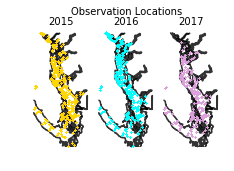

In [18]:
fig = plt.figure(figsize = (3,2))
#gsL = gridspec.GridSpec(1,1,left=.08,right=.98,hspace=.2,bottom=.015,top=.94)
#axL2015=fig.add_subplot(gsL[0,0])
#axL=fig.add_subplot(111)
#axL2017=fig.add_subplot(gsL[2,0])
gsLmap=gridspec.GridSpec(1,3,left=.08,right=.98,hspace=.2,bottom=.015,top=.94,wspace=.01)
axLmap2015=fig.add_subplot(gsLmap[0])
axLmap2016=fig.add_subplot(gsLmap[1])
axLmap2017=fig.add_subplot(gsLmap[2])

#viz_tools.set_aspect(axLmap)
for axLi in (axLmap2015,axLmap2016,axLmap2017):
    axLi.set_aspect(1, adjustable='box')
    contour_lines = axLi.contour(blon,blat,bathyZ,[0],
                colors='black',zorder=2,linewidth=.5,alpha=.8)
    axLi.set_xlim(-1.02,0.81)
    axLi.set_ylim(-1.5,1.8)
    axLi.axis('off')
datanut2015=data2015.loc[(data2015.CT>=0)|(data2015.SA>=0)]
datanut2016=data2016.loc[(data2016.CT>=0)|(data2016.SA>=0)]
datanut2017=data2017.loc[(data2017.CT>=0)|(data2017.SA>=0)]
#dataChl2015=data2015.loc[(data2015.Chl>=0)]
#dataChl2016=data2016.loc[(data2016.Chl>=0)]
#dataChl2017=data2017.loc[(data2017.Chl>=0)]
lons15,lats15=rotmap(datanut2015['Lon'], datanut2015['Lat'],lon0,lat0,theta)
lons16,lats16=rotmap(datanut2016['Lon'], datanut2016['Lat'],lon0,lat0,theta)
lons17,lats17=rotmap(datanut2017['Lon'], datanut2017['Lat'],lon0,lat0,theta)
#lons15chl,lats15chl=rotmap(dataChl2015['Lon'], dataChl2015['Lat'],lon0,lat0,theta)
#lons16chl,lats16chl=rotmap(dataChl2016['Lon'], dataChl2016['Lat'],lon0,lat0,theta)
#lons17chl,lats17chl=rotmap(dataChl2017['Lon'], dataChl2017['Lat'],lon0,lat0,theta)
axLmap2015.plot(lons15,lats15, '.',color='gold',markersize=1)
axLmap2016.plot(lons16,lats16, '.',color='aqua',markersize=1)
axLmap2017.plot(lons17,lats17, '.',color='plum',markersize=1)
#axLmap2015.plot(lons15chl,lats15chl, '.',color='darkorange',markersize=2)
#axLmap2016.plot(lons16chl,lats16chl, '.',color='teal',markersize=2)
#axLmap2017.plot(lons17chl,lats17chl, '.',color='darkviolet',markersize=2)
axLmap2015.set_title('2015')
axLmap2016.set_title('2016')
axLmap2017.set_title('2017')
axLmap2016.annotate('Observation Locations',xy=[.5,1.14],xycoords='axes fraction',ha='center')

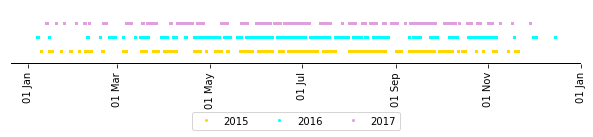

In [26]:
fig,axL=plt.subplots(1,1,figsize=(18,1))
p1,=axL.plot(datanut2015.dtUTC,np.zeros(np.shape(datanut2015.dtUTC)),'.',color='gold',markersize=4,label='2015')
p2,=axL.plot(datanut2016.dtUTC-dt.datetime(2016,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(datanut2016.dtUTC))+.1,'.',color='aqua',markersize=4,label='2016')
p3,=axL.plot(datanut2017.dtUTC-dt.datetime(2017,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(datanut2017.dtUTC))+.2,'.',color='plum',markersize=4,label='2017')
#p1,=axL.plot(dataChl2015.dtUTC,np.zeros(np.shape(dataChl2015.dtUTC)),'.',color='darkorange',markersize=6,label='2015')
#p2,=axL.plot(dataChl2016.dtUTC-dt.datetime(2016,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(dataChl2016.dtUTC))+.1,'.',color='teal',markersize=6,label='2016')
#p3,=axL.plot(dataChl2017.dtUTC-dt.datetime(2017,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(dataChl2017.dtUTC))+.2,'.',color='darkviolet',markersize=6,label='2017')
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
yy=2015
axL.xaxis.set_ticks([dt.datetime(int(yy),1,1), dt.datetime(int(yy),3,1),dt.datetime(int(yy),5,1),dt.datetime(int(yy),7,1),
                     dt.datetime(int(yy),9,1),dt.datetime(int(yy),11,1),dt.datetime(int(yy)+1,1,1)])
#labels=axL.xaxis.get_ticklabels()
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.3)
axLpos=axL.get_position()
new = mpl.transforms.Bbox.from_bounds(0.05,axLpos.bounds[1],0.44,axLpos.bounds[3])
axL.set_position(new)
axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-1.3])
axL.set_frame_on(False)
#axL.axes.get_yaxis().set_visible(False)
#axL.axes.get_xaxis().set_visible(True)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))